In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from collections import deque
import time
import pandas as pd

In [3]:
def moving_average(a, n=3): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim,out_features=128), 
            nn.ReLU(True),
            nn.Linear(in_features=128,out_features=128), 
            nn.ReLU(True),
            nn.Linear(in_features=128,out_features=action_space_dim)
        )

    def forward(self, x):
        return self.linear(x) 

In [5]:
class DQNAgent:
    def __init__(self, params):
        
        self.state_size = params['state_size']
        self.action_size = params['action_size']
        
        self.memory = deque(maxlen = 15_000)
        self.min_sampl = 500
        
        self.target_up = params['target_up']
        
        self.gamma = params['gamma']
        
        self.eps = 1.
        
        self.model = DQN(self.state_size, self.action_size)
        self.t_model = DQN(self.state_size, self.action_size)
        self.t_model.load_state_dict(self.model.state_dict())
        
        self.opt = torch.optim.Adam(self.model.parameters(), lr=params['lr'])
        self.loss_fn = nn.SmoothL1Loss()
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.eps:
            return np.random.randint(self.action_size)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values).item()
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                with torch.no_grad():
                    target = (reward + self.gamma * torch.max(self.t_model(next_state)))
            
            target = torch.tensor(target).reshape((1))
            predected = self.model(state)[:,action]
               
                
            #print(predected, target)
            loss = self.loss_fn(predected, target)

            self.opt.zero_grad()
            loss.backward()
        
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay
            
            
    def replay_2(self,batch_size):
        
        # Sample the data from the replay memory
        batch = random.sample(self.memory, batch_size)

        # Create tensors for each element of the batch
        states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
        rewards     = torch.tensor([s[2] for s in batch], dtype=torch.float32)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[3] for s in batch if s[3] is not None], dtype=torch.float32) # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[3] is not None for s in batch], dtype=torch.bool)

        # Compute all the Q values (forward pass)
        self.model.train()
        q_values = self.model(states)
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1))

        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            self.t_model.eval()
            q_values_target = self.t_model(non_final_next_states)
        next_state_max_q_values = torch.zeros(batch_size)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * self.gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

        # Compute the Huber loss
        loss = self.loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        self.opt.zero_grad()
        loss.backward()
        # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
        nn.utils.clip_grad_norm_(self.model.parameters(), 2)
        self.opt.step()
        
        #if self.eps > self.eps_min:
        #    self.eps *= self.eps_decay

In [14]:
def train(agent, epochs, lamb):
    exp_decay = np.exp(-np.log(5) / epochs * lamb) 
    exploration_profile = [(exp_decay ** i) for i in range(epochs)]

    pbar = tqdm(range(epochs))
    SCORE = []
    for e in pbar:
        agent.eps = max(exploration_profile[e], 1e-4)
        state = env.reset()
        state = state.astype(np.float32)
        done = False
        score = 0
        step = 0
        while not done and step < 2000:

            step += 1
            
            state_t = torch.from_numpy(state).unsqueeze(0)
            action = agent.act(state_t)

            next_state, reward, done, _ = env.step(action)
            
            
            reward -= 1. * np.abs(state[0])
            
            next_state = next_state.astype(np.float32)
            if done:
                next_state = None

            agent.remember(state, action, reward, next_state, done)


            if len(agent.memory) > agent.min_sampl:
                agent.replay_2(32)

            state = next_state
            score += reward 

            
        SCORE.append(step)
        
        if e % agent.target_up == 0:
            agent.t_model.load_state_dict(agent.model.state_dict())

        if e % 10 == 0:
            mean_score = np.mean(SCORE[-10:])
            desc = 'Mean score: ' + str(int(mean_score)) + '\t' + str(agent.eps)
            pbar.set_description(desc)
            
        if np.mean(SCORE[-10:]) == 500:
            break
                    
            
        
    return SCORE

In [15]:
env = gym.make('CartPole-v1')


env.seed(1012390)
torch.manual_seed(1012903)
np.random.seed(1019023)
random.seed(1013902)

params = {
    'state_size': 4,
    'action_size': 2,
    'lr': 1e-3,
    'gamma': 0.97,
    'target_up': 5,
}

agent = DQNAgent(params)

epochs = 1000

lamb = 5

SCORE = train(agent, epochs, lamb)


env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

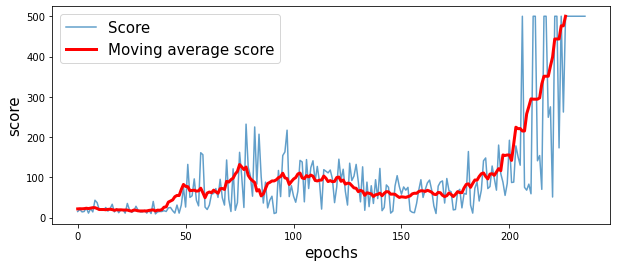

In [16]:
plt.figure(figsize=(10,4))
plt.plot(SCORE,label= 'Score', alpha = 0.7)
plt.plot(moving_average(SCORE,10), color= 'r', linewidth = 3 , label= 'Moving average score')
plt.xlabel("epochs",fontsize=15)
plt.ylabel("score",fontsize=15)

plt.legend(fontsize=15)

plt.savefig("img/cart_conv.png",dpi = 300)

In [17]:
torch.save(agent.model.state_dict(), "cart_model.h5")

In [18]:
params = {
    'state_size': 4,
    'action_size': 2,
    'lr': 1e-3,
    'gamma': 0.97,
    'target_up': 5,
}


tr_agent = DQNAgent(params)
tr_agent.model.load_state_dict(torch.load("cart_model.h5"))


<All keys matched successfully>

In [19]:
env.seed(102) 
state = env.reset()

tr_agent.eps = 0.

score = 0
done = False

frames = []

for i in tqdm(range(400)):
    state = state.astype(np.float32)
    state_t = torch.from_numpy(state).unsqueeze(0)
    action = tr_agent.act(state_t)
    next_state, reward, done, info = env.step(action)
    env.render()
    score += reward 
    state = next_state
    if done: break
    
env.close()


  0%|          | 0/400 [00:00<?, ?it/s]

### Different $\lambda$

In [27]:
env.seed(1012390)
env.reset()
torch.manual_seed(1012903)
np.random.seed(1019023)
random.seed(1013902)

LAMBDAS = [2,4,8,16]
SCORES = []
for lamb in LAMBDAS:

    params = {
        'state_size': 4,
        'action_size': 2,
        'lr': 1e-3,
        'gamma': 0.97,
        'target_up': 5,
    }

    agent = DQNAgent(params)

    epochs = 1000

    SCORE = train(agent, epochs, lamb)

    SCORES.append(SCORE)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

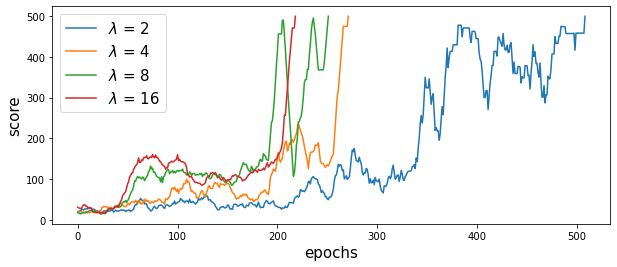

In [31]:
plt.figure(figsize=(10,4))
plt.xlabel("epochs",fontsize=15)
plt.ylabel("score",fontsize=15)


for i,s in enumerate(SCORES):
    plt.plot(moving_average(s,10), label = '$\lambda$ = '+str(LAMBDAS[i]))

plt.legend(fontsize=15)

plt.savefig("img/cart_conv_lambdas.png",dpi = 300)

### Random search

In [45]:
env.seed(1012390)
env.reset()
torch.manual_seed(1012903)
np.random.seed(1019023)
random.seed(1013902)

P = []
for j in range(30):

    params = {
        'state_size': 4,
        'action_size': 2,
        'lr': np.random.choice([1e-2,1e-3, 1e-4]),
        'gamma': np.random.choice([0.9,0.95, 0.99]),
        'target_up': np.random.choice([2,5,10]),
    }

    agent = DQNAgent(params)

    epochs = 500

    lamb = 4
    
    print(params)
    SCORE = train(agent, epochs, lamb)

    params['score'] = SCORE[-1]    
    params['steps'] = len(SCORE)
    
    P.append(params)

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.9, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.95, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.99, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.9, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.95, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.95, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.95, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.99, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.9, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.95, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.99, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.95, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.95, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.95, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.99, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.95, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.95, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.95, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.99, 'target_up': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.001, 'gamma': 0.95, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.0001, 'gamma': 0.99, 'target_up': 5}


  0%|          | 0/500 [00:00<?, ?it/s]

{'state_size': 4, 'action_size': 2, 'lr': 0.01, 'gamma': 0.9, 'target_up': 2}


  0%|          | 0/500 [00:00<?, ?it/s]

In [55]:
import pandas as pd

keys = P[0].keys()
df = {}
for k in keys:
    df[k] = []
    for p in P:
        df[k].append(p[k])

df = pd.DataFrame.from_dict(df)#.sort_values(by = 'steps').sort_values(by = ['score', 'steps'], ascending = [False, True]).reset_index(drop=True)
#df[["lr", "gamma", "target_up", "score", "steps"]]

df["efficiency"] = df["score"]/df["steps"]
df = df.sort_values(by = 'efficiency', ascending = False).reset_index(drop = True)

df

,state_size,action_size,lr,gamma,target_up,score,steps,efficiency
0,4,2,0.0100,0.99,2,500,147,3.401361
1,4,2,0.0100,0.95,2,500,169,2.958580
2,4,2,0.0010,0.95,2,500,185,2.702703
3,4,2,0.0100,0.99,5,500,221,2.262443
4,4,2,0.0100,0.95,2,500,227,2.202643
5,4,2,0.0100,0.99,5,500,231,2.164502
6,4,2,0.0100,0.95,2,500,242,2.066116
7,4,2,0.0010,0.95,5,500,335,1.492537
8,4,2,0.0010,0.95,5,500,338,1.479290
9,4,2,0.0100,0.99,10,500,431,1.160093


In [63]:
df = pd.read_csv("hyp_cart_pole.csv")
df.head()

,Unnamed: 0,state_size,action_size,lr,gamma,target_up,score,steps,efficiency
0,0,4,2,0.010,0.99,2,500,147,3.401361
1,1,4,2,0.010,0.95,2,500,169,2.958580
2,2,4,2,0.001,0.95,2,500,185,2.702703
3,3,4,2,0.010,0.99,5,500,221,2.262443
4,4,4,2,0.010,0.95,2,500,227,2.202643


In [72]:
df = df[["lr","gamma","target_up","steps","score"]].groupby(["lr","gamma","target_up"]).first().reset_index()
df = df.sort_values(by = ['score', 'steps'], ascending = [False, True]).reset_index(drop=True)
#df = df.groupby(["lr","gamma","target_up"]).first().reset_index()

df

,lr,gamma,target_up,steps,score
0,0.0100,0.99,2,147,500
1,0.0100,0.95,2,169,500
2,0.0010,0.95,2,185,500
3,0.0100,0.99,5,221,500
4,0.0010,0.95,5,335,500
5,0.0100,0.99,10,431,500
6,0.0001,0.90,2,500,131
7,0.0001,0.95,10,500,125
8,0.0100,0.90,2,500,115
9,0.0100,0.90,10,500,105
